In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dateutil
from sklearn import ensemble,metrics,linear_model,tree

# Read All data

In [2]:
campData=pd.read_csv('campaign_data.csv')
coupon_item_mappingData=pd.read_csv('coupon_item_mapping.csv')
customer_demographicsData=pd.read_csv('customer_demographics.csv')
customer_transaction_dataData=pd.read_csv('customer_transaction_data.csv')
item_dataData=pd.read_csv('item_data.csv')
trainData=pd.read_csv('train.csv')
test_QyjYwdjData=pd.read_csv('test_QyjYwdj.csv')

In [3]:
customer_transaction_dataData.shape

(1324566, 7)

In [4]:
trainData['dtType']='train'
test_QyjYwdjData['dtType']='test'

allData=trainData.append(test_QyjYwdjData,sort=False)
allData.shape

(128595, 6)

## feature in  Camp Data

In [5]:
campData['start_date']=campData['start_date'].apply(lambda x: dateutil.parser.parse(x,dayfirst=True))
campData['end_date']=campData['end_date'].apply(lambda x: dateutil.parser.parse(x,dayfirst=True))
campData['duration']=campData['end_date']-campData['start_date']
campData['duration']=campData['duration'].apply(lambda x: x.days)
campData['start_Month']=campData['start_date'].apply(lambda x: x.month)
campData['end_Month']=campData['end_date'].apply(lambda x: x.month)

In [6]:
campData.head()

,campaign_id,campaign_type,start_date,end_date,duration,start_Month,end_Month
0,24,Y,2013-10-21,2013-12-20,60,10,12
1,25,Y,2013-10-21,2013-11-22,32,10,11
2,20,Y,2013-09-07,2013-11-16,70,9,11
3,23,Y,2013-10-08,2013-11-15,38,10,11
4,21,Y,2013-09-16,2013-10-18,32,9,10


In [7]:
#customer previous campaign reaction
# item data transaction data merged4
# train data and camp data merged

## Merge transaction data and Item data

In [8]:
transItemData=pd.merge(customer_transaction_dataData,item_dataData,on='item_id',how='left')
transItemData.shape

(1324566, 10)

In [9]:
transItemData.head(2)

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,brand,brand_type,category
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0,56,Local,Natural Products
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0,56,Local,Natural Products


# Merge traindata with Campdata

In [10]:
trainCampDatamerge=pd.merge(trainData,campData,on='campaign_id',how='left')
trainCampDatamerge.shape,trainData.shape

((78369, 12), (78369, 6))

In [11]:
trainCampDatamerge.head(2)

,id,campaign_id,coupon_id,customer_id,redemption_status,dtType,campaign_type,start_date,end_date,duration,start_Month,end_Month
0,1,13,27,1053,0,train,X,2013-05-19,2013-07-05,47,5,7
1,2,13,116,48,0,train,X,2013-05-19,2013-07-05,47,5,7


## Feature engg in coupon mapping data and item data and transaction data

### merge mapping dtaa and transaction data

In [12]:
itenACoupData=pd.merge(coupon_item_mappingData,item_dataData,on='item_id',how='left').sort_values('coupon_id')

In [13]:
itenACoupData.head(2)

,coupon_id,item_id,brand,brand_type,category
31428,1,47797,1475,Established,Natural Products
31427,1,67376,4700,Established,Natural Products


### feature from transaction data Item level

In [14]:
itemInfoFromTransaction=customer_transaction_dataData.groupby('item_id',as_index=False).agg({'selling_price':'mean',
                                                                     'coupon_discount':{'discountCount':'count','totalDisc':'sum'},
                                                                    'other_discount':{'OTdiscountCount':'count','OTtotalDisc':'sum'}})
itemInfoFromTransaction.columns=[''.join(j) for j in itemInfoFromTransaction.columns]

C:\Users\swsh\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\pandas\core\groupby\generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [15]:
itemInfoFromTransaction['dicountPerGiven']=itemInfoFromTransaction['coupon_discounttotalDisc']/itemInfoFromTransaction['coupon_discountdiscountCount']
itemInfoFromTransaction['dicountOthPerGiven']=itemInfoFromTransaction['other_discountOTtotalDisc']/itemInfoFromTransaction['other_discountOTdiscountCount']
itemInfoFromTransaction['dicountGivenPerc']=itemInfoFromTransaction['dicountPerGiven']/itemInfoFromTransaction['selling_pricemean']
itemInfoFromTransaction['dicountOthPerGivenPerc']=itemInfoFromTransaction['dicountOthPerGiven']/itemInfoFromTransaction['selling_pricemean']


In [16]:
itemInfoFromTransaction.head(2)

,item_id,selling_pricemean,coupon_discountdiscountCount,coupon_discounttotalDisc,other_discountOTdiscountCount,other_discountOTtotalDisc,dicountPerGiven,dicountOthPerGiven,dicountGivenPerc,dicountOthPerGivenPerc
0,1,124.31,2,0.0,2,0.0,0.0,0.0,0.0,0.0
1,2,35.26,1,0.0,1,0.0,0.0,0.0,0.0,0.0


In [17]:
itenACoupData.shape,itemInfoFromTransaction.shape,coupon_item_mappingData.shape,item_dataData.shape

((92663, 5), (74063, 10), (92663, 2), (74066, 4))

In [18]:
itenACoupData.head(2)

,coupon_id,item_id,brand,brand_type,category
31428,1,47797,1475,Established,Natural Products
31427,1,67376,4700,Established,Natural Products


### merge item information from transaction to coupon item information

In [19]:
mergedItemCoupon=pd.merge(itenACoupData,itemInfoFromTransaction,on='item_id',how='left').fillna(0)

#some  null values present

In [20]:
mergedItemCoupon.head()

,coupon_id,item_id,brand,brand_type,category,selling_pricemean,coupon_discountdiscountCount,coupon_discounttotalDisc,other_discountOTdiscountCount,other_discountOTtotalDisc,dicountPerGiven,dicountOthPerGiven,dicountGivenPerc,dicountOthPerGivenPerc
0,1,47797,1475,Established,Natural Products,88.690000,1.0,0.00,1.0,0.00,0.000000,0.000000,0.000000,0.000000
1,1,67376,4700,Established,Natural Products,47.373333,3.0,0.00,3.0,0.00,0.000000,0.000000,0.000000,0.000000
2,1,59942,1475,Established,Natural Products,105.293000,10.0,-359.76,10.0,-282.10,-35.976000,-28.210000,-0.341675,-0.267919
3,1,59841,1475,Established,Natural Products,98.226579,38.0,-137.14,38.0,-1551.55,-3.608947,-40.830263,-0.036741,-0.415674
4,1,67131,1475,Established,Natural Products,92.254845,97.0,-19.59,97.0,-4134.89,-0.201959,-42.627732,-0.002189,-0.462065


In [21]:
coupon_categFind=mergedItemCoupon.groupby(['coupon_id','category','brand','brand_type'],as_index=False).count()[['coupon_id','category','brand','brand_type','item_id']]

In [22]:
coupon_categFind.head()

,coupon_id,category,brand,brand_type,item_id
0,1,Grocery,1558,Established,9
1,1,Natural Products,1475,Established,25
2,1,Natural Products,4700,Established,5
3,2,Grocery,2084,Established,2
4,3,Grocery,278,Established,12


In [23]:
coupon_categFind=coupon_categFind.sort_values(['coupon_id','item_id'],ascending=False)
coupon_categFind=coupon_categFind.drop_duplicates('coupon_id')

In [24]:
del coupon_categFind['item_id']

In [25]:
coupon_categFind.head()

,coupon_id,category,brand,brand_type
8472,1116,Pharmaceutical,4728,Established
8471,1115,Grocery,2446,Established
8470,1114,Pharmaceutical,2416,Established
8469,1113,Pharmaceutical,5184,Established
8468,1112,Grocery,5177,Established


In [26]:
mergedItemCoupon[mergedItemCoupon['selling_pricemean'].isnull()]

,coupon_id,item_id,brand,brand_type,category,selling_pricemean,coupon_discountdiscountCount,coupon_discounttotalDisc,other_discountOTdiscountCount,other_discountOTtotalDisc,dicountPerGiven,dicountOthPerGiven,dicountGivenPerc,dicountOthPerGivenPerc


## Feature from customer data

In [27]:
customerProfileData=customer_transaction_dataData.groupby('customer_id',as_index=False).agg({'quantity':'sum','date':'nunique','item_id':'count',
                                                                        'selling_price':{'maxSP':'max','minSP':'min',
                                                                                        'averageSP':'mean'},
                                                                        'other_discount':{'maxOD':'max','minOD':'min',
                                                                                        'averageOD':'mean'},
                                                                        'coupon_discount':{'maxCD':'max','minCD':'min',
                                                                                        'averageCD':'mean','totalCDAvailed':'count'}})

customerProfileData.columns = ['_'.join(col) for col in customerProfileData.columns.values]

In [28]:
customerProfileData.head(2)

,customer_id_,quantity_sum,date_nunique,item_id_count,selling_price_maxSP,selling_price_minSP,selling_price_averageSP,other_discount_maxOD,other_discount_minOD,other_discount_averageOD,coupon_discount_maxCD,coupon_discount_minCD,coupon_discount_averageCD,coupon_discount_totalCDAvailed
0,1,1227,56,1048,445.25,12.11,94.001842,0.0,-372.23,-16.250382,0.0,-106.86,-2.019876,1048
1,2,474,37,419,640.80,14.25,102.864033,0.0,-312.03,-16.830430,0.0,-89.05,-0.595084,419


### Clustering on  transaction item data information to get information about coupons

In [29]:
mergedItemCoupon.head(2)

,coupon_id,item_id,brand,brand_type,category,selling_pricemean,coupon_discountdiscountCount,coupon_discounttotalDisc,other_discountOTdiscountCount,other_discountOTtotalDisc,dicountPerGiven,dicountOthPerGiven,dicountGivenPerc,dicountOthPerGivenPerc
0,1,47797,1475,Established,Natural Products,88.690000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,67376,4700,Established,Natural Products,47.373333,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [30]:
datatoCluster=mergedItemCoupon.groupby('coupon_id',as_index=False).mean()[['coupon_id', 
       'selling_pricemean', 'coupon_discountdiscountCount',
       'coupon_discounttotalDisc', 'other_discountOTdiscountCount',
       'other_discountOTtotalDisc', 'dicountPerGiven', 'dicountOthPerGiven',
       'dicountGivenPerc', 'dicountOthPerGivenPerc']]

In [31]:
clusVar=['coupon_id', 
       'selling_pricemean', 'coupon_discountdiscountCount',
       'coupon_discounttotalDisc', 'other_discountOTdiscountCount',
       'other_discountOTtotalDisc', 'dicountPerGiven', 'dicountOthPerGiven',
       'dicountGivenPerc', 'dicountOthPerGivenPerc']

In [32]:
from sklearn import preprocessing,cluster,decomposition

In [33]:
preProCl=preprocessing.StandardScaler()
clusData=preProCl.fit_transform(datatoCluster[clusVar])

C:\Users\swsh\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\swsh\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [34]:
pcaComp=decomposition.PCA()

In [35]:
pcaData=pcaComp.fit_transform(clusData)

In [36]:
pcaComp.explained_variance_ratio_

array([2.73909700e-01, 2.23110443e-01, 1.61180496e-01, 1.04585701e-01,
       9.25216218e-02, 6.78197557e-02, 3.71310568e-02, 2.26283535e-02,
       1.71128729e-02, 1.30621511e-33])

In [37]:
pcaDataFToGraph=pd.DataFrame(pcaData[:,:2],columns=['pca1','pca2'])

In [38]:
kM=cluster.KMeans()

In [39]:
pcaDataFToGraph['clusCat']=kM.fit_predict(clusData[:,:5])

In [40]:
pcaDataFToGraph.head(2)

,pca1,pca2,clusCat
0,0.229347,-0.194417,2
1,0.906231,-0.775508,6


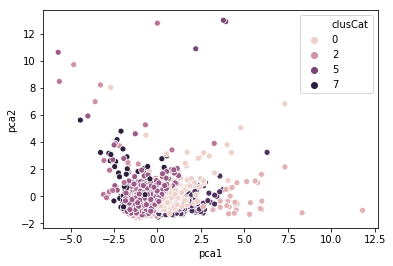

In [41]:
sns.scatterplot(pcaDataFToGraph['pca1'],pcaDataFToGraph['pca2'],hue=pcaDataFToGraph['clusCat'])

In [42]:
pcaDataFToGraph['clusCat']=pcaDataFToGraph['clusCat'].map(str)

In [43]:
pcaDataTOCoup=pd.concat([datatoCluster[['coupon_id']],pcaDataFToGraph],axis=1)

In [44]:
# crosstabData=pd.pivot_table(coupon_item_mappingData,index='coupon_id',columns='item_id',values='val',aggfunc=np.sum).fillna(0)
# coupon_idData=trainCampDatamerge.groupby('coupon_id',as_index=False).agg({'redemption_status':'sum'})
# coupon_idData[coupon_idData['redemption_status']>1]

# Final data for model prep

In [45]:
X1=pd.merge(allData,coupon_categFind,on='coupon_id',how='left')
X2=pd.merge(X1,datatoCluster,on='coupon_id',how='left')
X3=pd.merge(X2,pcaDataTOCoup,on='coupon_id',how='left')
X4=pd.merge(X3,campData,on='campaign_id',how='left')
X5=pd.merge(X4,customer_demographicsData,on='customer_id',how='left')
X6=pd.merge(X5,customerProfileData,left_on='customer_id',right_on='customer_id_',how='left')


In [46]:
customerProfileData.head(2)

,customer_id_,quantity_sum,date_nunique,item_id_count,selling_price_maxSP,selling_price_minSP,selling_price_averageSP,other_discount_maxOD,other_discount_minOD,other_discount_averageOD,coupon_discount_maxCD,coupon_discount_minCD,coupon_discount_averageCD,coupon_discount_totalCDAvailed
0,1,1227,56,1048,445.25,12.11,94.001842,0.0,-372.23,-16.250382,0.0,-106.86,-2.019876,1048
1,2,474,37,419,640.80,14.25,102.864033,0.0,-312.03,-16.830430,0.0,-89.05,-0.595084,419


In [47]:
X5.head(2)

,id,campaign_id,coupon_id,customer_id,redemption_status,dtType,category,brand,brand_type,selling_pricemean,...,end_date,duration,start_Month,end_Month,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,13,27,1053,0.0,train,Grocery,1105,Established,84.478583,...,2013-07-05,47,5,7,46-55,NaN,0.0,1,NaN,5.0
1,2,13,116,48,0.0,train,Grocery,56,Local,63.833519,...,2013-07-05,47,5,7,36-45,Married,0.0,2,NaN,3.0


In [48]:
X5['marital_status']=X5['marital_status'].fillna('Other')
X5['rented']=X5['rented'].fillna(0)
X5['no_of_children']=X5['no_of_children'].fillna(0)
X5['age_range']=X5['age_range'].fillna('Other')
X5['family_size']=X5['family_size'].fillna('Other')
X5['income_bracket']=X5['income_bracket'].fillna('Other')

In [49]:
X5.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'dtType', 'category', 'brand', 'brand_type', 'selling_pricemean',
       'coupon_discountdiscountCount', 'coupon_discounttotalDisc',
       'other_discountOTdiscountCount', 'other_discountOTtotalDisc',
       'dicountPerGiven', 'dicountOthPerGiven', 'dicountGivenPerc',
       'dicountOthPerGivenPerc', 'pca1', 'pca2', 'clusCat', 'campaign_type',
       'start_date', 'end_date', 'duration', 'start_Month', 'end_Month',
       'age_range', 'marital_status', 'rented', 'family_size',
       'no_of_children', 'income_bracket'],
      dtype='object')

In [50]:
categoColumns=['category','clusCat','campaign_type', 'brand_type','age_range','marital_status','family_size','no_of_children','income_bracket']
catData=pd.get_dummies(X5[categoColumns],prefix_sep='_',)

In [58]:
newtData=pd.concat([X5,catData],sort=False,axis=1)

In [59]:
XVar=list(newtData.columns)
XVar.remove('id')
XVar.remove('redemption_status')
XVar.remove('dtType')
XVar.remove('start_date')
XVar.remove('end_date')
YVar='redemption_status'

In [60]:
for j in categoColumns+['campaign_id', 'coupon_id', 'customer_id']:
    XVar.remove(j)

In [61]:
trainPart=newtData[newtData['dtType']=='train']
testPart=newtData[newtData['dtType']=='test']
trainPart.shape,testPart.shape

((78369, 89), (50226, 89))

In [62]:
XVar

['brand',
 'selling_pricemean',
 'coupon_discountdiscountCount',
 'coupon_discounttotalDisc',
 'other_discountOTdiscountCount',
 'other_discountOTtotalDisc',
 'dicountPerGiven',
 'dicountOthPerGiven',
 'dicountGivenPerc',
 'dicountOthPerGivenPerc',
 'pca1',
 'pca2',
 'duration',
 'start_Month',
 'end_Month',
 'rented',
 'category_Bakery',
 'category_Dairy, Juices & Snacks',
 'category_Flowers & Plants',
 'category_Grocery',
 'category_Meat',
 'category_Natural Products',
 'category_Packaged Meat',
 'category_Pharmaceutical',
 'category_Prepared Food',
 'category_Seafood',
 'category_Skin & Hair Care',
 'clusCat_0',
 'clusCat_1',
 'clusCat_2',
 'clusCat_3',
 'clusCat_4',
 'clusCat_5',
 'clusCat_6',
 'clusCat_7',
 'campaign_type_X',
 'campaign_type_Y',
 'brand_type_Established',
 'brand_type_Local',
 'age_range_18-25',
 'age_range_26-35',
 'age_range_36-45',
 'age_range_46-55',
 'age_range_56-70',
 'age_range_70+',
 'age_range_Other',
 'marital_status_Married',
 'marital_status_Other',
 

In [63]:
from sklearn import model_selection,metrics
import xgboost as xgb

## Train test Split Train, Val, Test set

In [64]:
trainX,testHX,trainY,testHY=model_selection.train_test_split(trainPart[XVar],trainPart[YVar],test_size=.2,stratify =trainPart[YVar])
trainX.shape,testHX.shape,trainY.shape,testHY.shape

((62695, 72), (15674, 72), (62695,), (15674,))

In [65]:
trainX1,valX1,trainY1,valY1=model_selection.train_test_split(trainX,trainY,test_size=.2,stratify =trainY)
trainX1.shape,valX1.shape,trainY1.shape,valY1.shape

((50156, 72), (12539, 72), (50156,), (12539,))

In [66]:
modelR=xgb.XGBClassifier().fit(trainX1,trainY1)

In [67]:
t1=modelR.predict(trainX)
t2=modelR.predict(valX1)
t3=modelR.predict(testHX)
trainScore=modelR.predict_proba(trainX)[:,1]
testScore=modelR.predict_proba(valX1)[:,1]
test2Score=modelR.predict_proba(testHX)[:,1]

print ('train {} vs {} validation {} vs {} test {} vs {}'.format(sum(trainY),sum(t1),sum(valY1),sum(t2), sum(testHY),sum(t3)))
metrics.roc_auc_score(trainY,trainScore),metrics.roc_auc_score(valY1,testScore),metrics.roc_auc_score(testHY,test2Score)

train 583.0 vs 0.0 validation 117.0 vs 0.0 test 146.0 vs 0.0


(0.8920734430493733, 0.8653990645215891, 0.8569519577537352)

In [68]:
import lightgbm  as lgb

In [69]:
modelL=lgb.LGBMClassifier().fit(trainX1,trainY1)

In [70]:
t1=modelL.predict(trainX)
t2=modelL.predict(valX1)
t3=modelL.predict(testHX)
trainScore=modelL.predict_proba(trainX)[:,1]
testScore=modelL.predict_proba(valX1)[:,1]
test2Score=modelL.predict_proba(testHX)[:,1]

print ('train {} vs {} validation {} vs {} test {} vs {}'.format(sum(trainY),sum(t1),sum(valY1),sum(t2), sum(testHY),sum(t3)))
metrics.roc_auc_score(trainY,trainScore),metrics.roc_auc_score(valY1,testScore),metrics.roc_auc_score(testHY,test2Score)

train 583.0 vs 134.0 validation 117.0 vs 13.0 test 146.0 vs 20.0


(0.9585126420219812, 0.851620780335963, 0.8526329811635014)

In [71]:
modelRF=ensemble.RandomForestClassifier().fit(trainX1,trainY1)

C:\Users\swsh\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [72]:
t1=modelRF.predict(trainX)
t2=modelRF.predict(valX1)
t3=modelRF.predict(testHX)
trainScore=modelRF.predict_proba(trainX)[:,1]
testScore=modelRF.predict_proba(valX1)[:,1]
test2Score=modelRF.predict_proba(testHX)[:,1]

print ('train {} vs {} validation {} vs {} test {} vs {}'.format(sum(trainY),sum(t1),sum(valY1),sum(t2), sum(testHY),sum(t3)))
metrics.roc_auc_score(trainY,trainScore),metrics.roc_auc_score(valY1,testScore),metrics.roc_auc_score(testHY,test2Score)

train 583.0 vs 284.0 validation 117.0 vs 20.0 test 146.0 vs 27.0


(0.9218274733939378, 0.6393092899694091, 0.6572740008327864)

In [73]:
params={'base_score':0.9,
        'booster':'gbtree', 
        'colsample_bylevel':1,
       'colsample_bytree':1, 
        'gamma':0, 
        'learning_rate':0.1, 
        'max_delta_step':0,
       'max_depth':3, 
        'min_child_weight':1, 
        'n_estimators':100,
        'eval_metric': ['logloss','auc'],
       'n_jobs':1,  'objective':'binary:logistic', 'random_state':0,
       'reg_alpha':0, 'reg_lambda':1, 'scale_pos_weight':1, 'subsample':1,
       'early_stopping_rounds' : 50,
       'stratified':True }

In [74]:
num_round = 1000

dtrain = xgb.DMatrix(trainX1,trainY1)
# dtrain.set_group(Xg)

dvalid = xgb.DMatrix(valX1, valY1)
# dvalid.set_group(Xgt)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
bst = xgb.train(params, dtrain, num_round, evals = watchlist,
    early_stopping_rounds=50,verbose_eval=10,maximize=True)


C:\Users\swsh\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:1.45769	train-auc:0.5	valid-logloss:1.45814	valid-auc:0.5
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-logloss:0.326257	train-auc:0.799989	valid-logloss:0.326237	valid-auc:0.819635
[20]	train-logloss:0.12951	train-auc:0.825288	valid-logloss:0.129571	valid-auc:0.835977
[30]	train-logloss:0.071259	train-auc:0.832648	valid-logloss:0.071406	valid-auc:0.839281
[40]	train-logloss:0.052966	train-auc:0.846586	valid-logloss:0.053179	valid-auc:0.850713
[50]	train-logloss:0.046898	train-auc:0.857163	valid-logloss:0.047248	valid-auc:0.858768
[60]	train-logloss:0.04453	train-auc:0.865892	valid-logloss:0.045342	valid-auc:0.857899
[70]	train-logloss:0.0432	train-auc:0.874338	valid-logloss:0.044395	valid-auc:0.860692
[80]	train-logloss:0.042394	train-auc:0.882599	valid-logloss:0.043993	valid-auc:0.862559
[90]	train-logloss:0.04161	train-auc:0.891322	valid-logloss:0.04371	valid

In [75]:
dtest = xgb.DMatrix(testHX)

In [76]:
testScoreP=bst.predict(dtest)

In [77]:
metrics.roc_auc_score(testHY,testScoreP)

0.8637640003387604

In [ ]:
# # testFScore=modelR.predict_proba(testPart[XVar])[:,1]
# firstSub2=pd.DataFrame(data={'id':test_QyjYwdjData['id'],YVar:testScoreP})
# firstSub2.to_csv('firstSub6.csv',index=False)